<br/>
# National Supported Work Demonstration
<br/>
<br/>
We will work with a by-now classic dataset from Robert LaLonde's study "<a href="http://people.hbs.edu/nashraf/LaLonde_1986.pdf">Evaluating the Econometric Evaluations of Training Programs</a>" (1986). The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program. Your task is to determine the effectiveness of the "treatment" represented by the job training program.
<br/>
<br/>
<br/>

In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Question 1: Propensity score matching
### 1. A naive analysis

In [204]:
pd.read_csv("lalonde.csv").shape

(614, 11)

In [205]:
dataset = pd.read_csv("lalonde.csv")
dataset.groupby('treat').mean()

,age,educ,black,hispan,married,nodegree,re74,re75,re78
treat,,,,,,,,,
0,28.030303,10.235431,0.202797,0.142191,0.512821,0.596737,5619.236506,2466.484443,6984.169742
1,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530


In [261]:
def draw_earning_78_plot(dataset):

    treatedGroup = dataset[dataset['treat'] == 1]
    controlGroup = dataset[dataset['treat'] == 0]
    meanByTreat = dataset.groupby('treat').mean()

    fig = plt.figure(figsize=(15, 20))
    fig.subplots_adjust(hspace=0.3)

    plt.subplot(3,2,1)
    tmp = controlGroup['re78'].plot.hist(by='re78',bins=15, normed=True)
    tmp.set_title('real earning in CONTROL group', fontsize=11)
    tmp.set_xlabel('real earning in 1978')
    
    plt.subplot(3,2,2)
    tmp = treatedGroup['re78'].plot.hist(by='re78',bins=15, normed=True)
    tmp.set_title('real earning in TREATED group', fontsize=11)
    tmp.set_xlabel('real earning in 1978')
    
    plt.subplot(3,2,3)
    tmp = controlGroup[['re78']].boxplot(showfliers=False)
    tmp.set_title('real earning in CONTROL group', fontsize=11)
    
    plt.subplot(3,2,4)
    tmp = treatedGroup[['re78']].boxplot(showfliers=False)
    tmp.set_title('real earning in TREATED group', fontsize=11)
    tmp.set_ylabel('real earning in 1978')

    plt.subplot(3,2,5)
    tmp = meanByTreat['re78'].copy()
    tmp.index = ['CONTROL', 'TREATED']
    tmp = tmp.plot(kind='bar');
    tmp.set_title('real earning mean comparison', fontsize=11)


    plt.show()

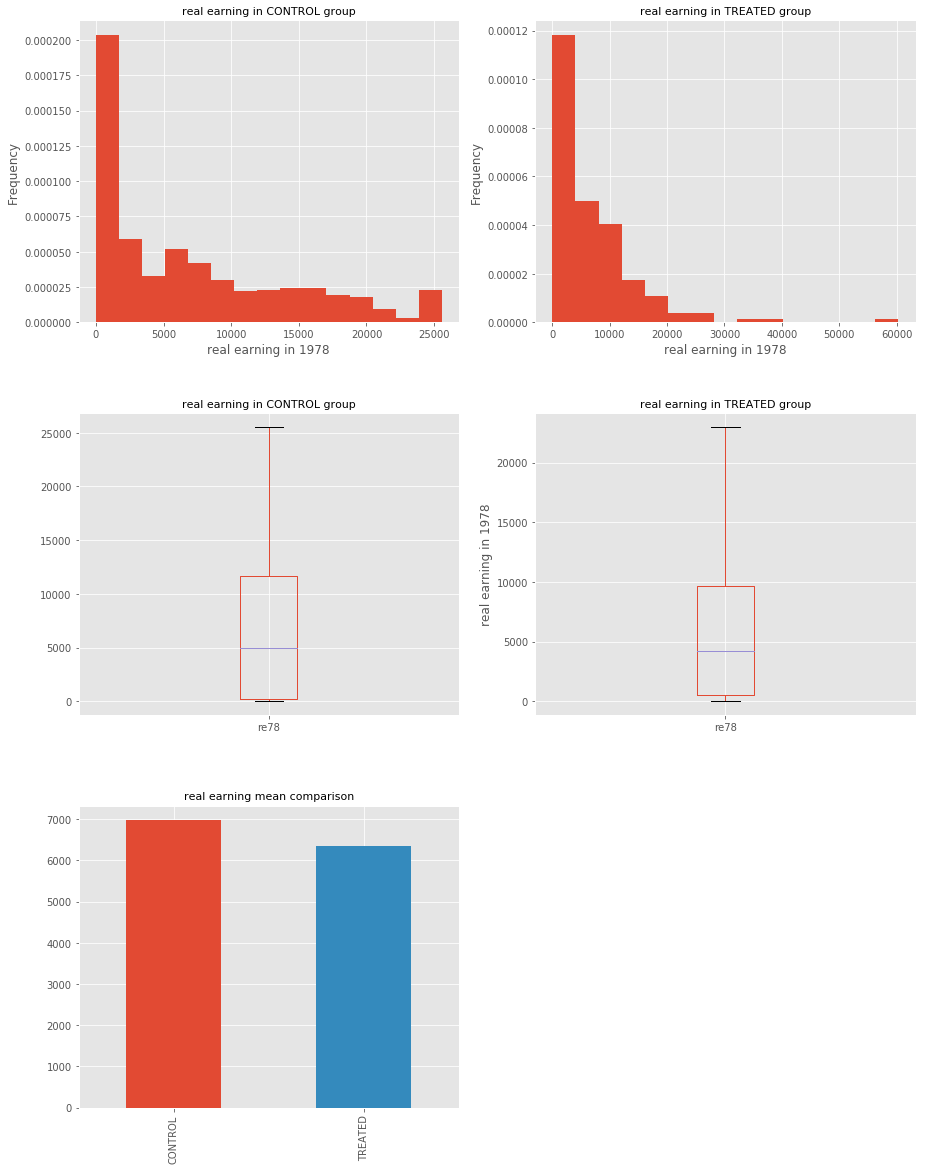

In [262]:
draw_earning_78_plot(dataset)

<br/>
<br/>
The control group has an higher revenue than the treated group. <br/>
The naive analysis would be to conclude that following a training course decreases the revenue.
<br/>

### 2. A closer look at the data

In [270]:
def build_mean_chart(meanValues, columnName):
    tmp = meanValues[columnName]
    tmp.index = ['CONTROL', 'TREATED']
    tmp = tmp.plot(kind='bar')
    tmp.set_title(columnName+' mean comparison')

    
def draw_feature_disparities_plot(dataset):
    
    meanByTreat = dataset.groupby('treat').mean()
        
    fig = plt.figure(figsize=(20, 20))
    fig.subplots_adjust(hspace=0.7)
    
    plt.subplot(3,3,1)
    build_mean_chart(meanByTreat, 'age')

    plt.subplot(3,3,2)
    build_mean_chart(meanByTreat, 'educ')

    plt.subplot(3,3,3)
    build_mean_chart(meanByTreat, 'black')

    plt.subplot(3,3,4)
    build_mean_chart(meanByTreat, 'hispan')

    plt.subplot(3,3,5)
    build_mean_chart(meanByTreat, 'married')

    plt.subplot(3,3,6)
    build_mean_chart(meanByTreat, 'nodegree')

    plt.subplot(3,3,7)
    build_mean_chart(meanByTreat, 're74')

    plt.subplot(3,3,8)
    build_mean_chart(meanByTreat, 're75')

    plt.show()



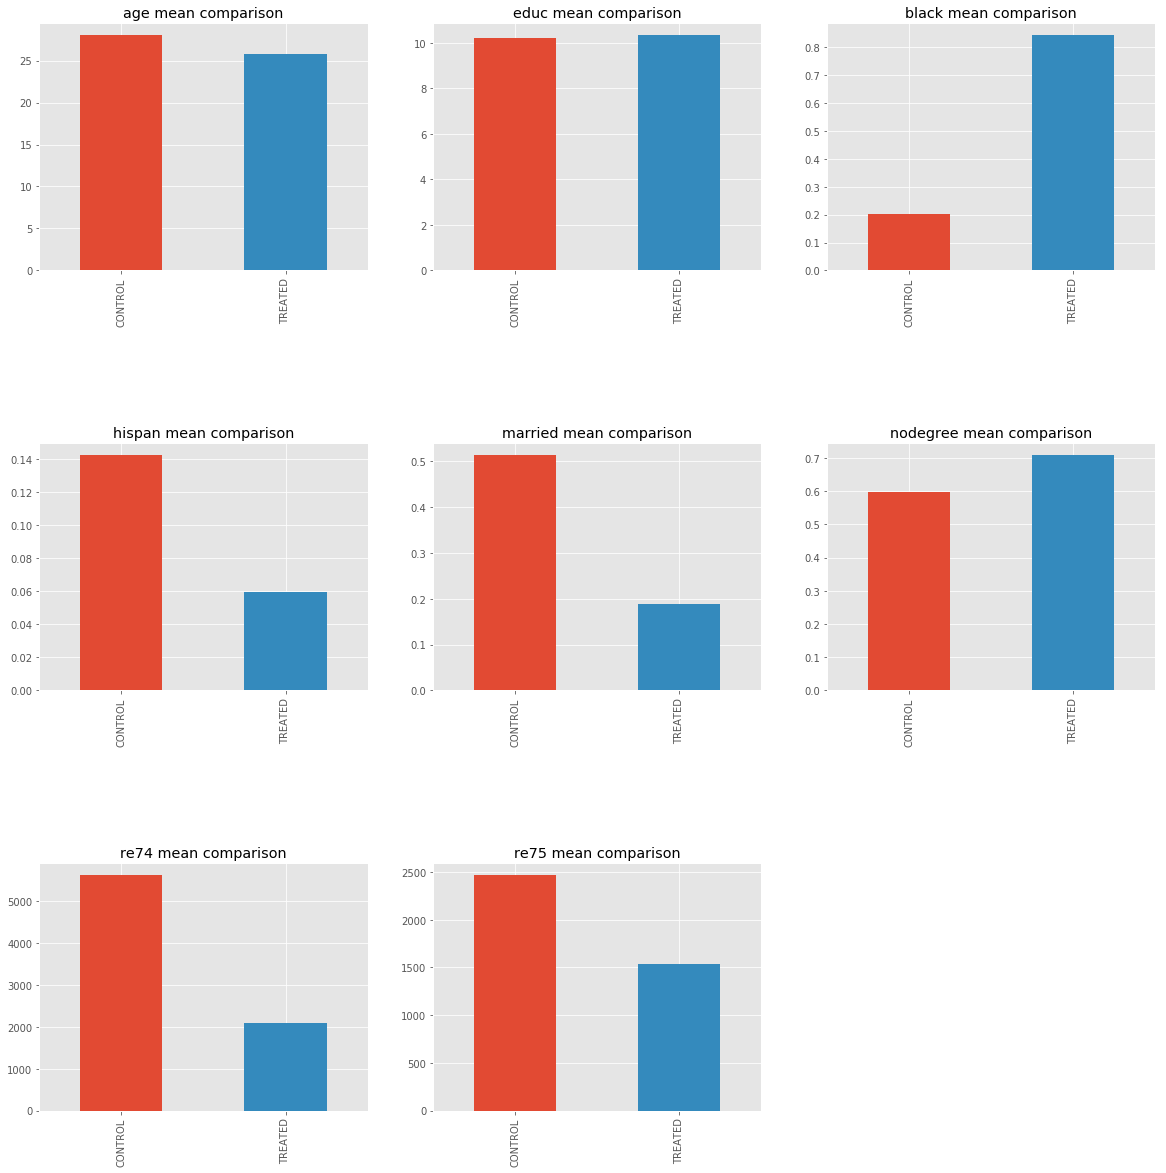

In [264]:
draw_feature_disparities_plot(dataset)

We can see that the control group and the treated one seems to be different.<br/>
To insure this property more fundamentally, we could verify using confidence interval.<br/>
However the black people mean percentage and the married mean percentage clearly shows disparities.<br/>
We can conclude that the 'treat' value is not drawn randomly from the population.<br/>
Therefore the naive conlusion is not relevant. 

### 3. A propensity score model

In [187]:
from sklearn import linear_model
from math import fabs
import networkx as nx
logistic = linear_model.LogisticRegression()

In [174]:
logistic.fit(dataset.loc[:,'age':'re75'], dataset.loc[:,'treat'])
propensityScores = logistic.predict_proba(dataset.loc[:,'age':'re75'])[:, 1]
dataset['propensityScore'] = propensityScores
hasError = np.logical_xor( propensityScores > 0.5, dataset.loc[:,'treat'] > 0.5 )
"has error : "+str(float(hasError.sum()/hasError.shape[0]*100))+"% of the time"

'has error : 19.218241042345277% of the time'

### 4. Balancing the dataset via matching

In [195]:
""" maximization function could be improve"""

G = nx.DiGraph()

for treatedId, treatedRecord in dataset[dataset['treat']==1].iterrows():
    for controlId, controlRecord in dataset[dataset['treat']==0].iterrows():
        absDistance = fabs(treatedRecord['propensityScore']-controlRecord['propensityScore']);
        absDistance = max(0.00000000000000000001, absDistance)
        G.add_edge(controlId, treatedId, capacity=1/absDistance);

matchings = nx.max_weight_matching(G,  maxcardinality=True)

In [255]:
ids = [currId for currId in matchings.values()]
balancedDataset = dataset.iloc[ids,:]

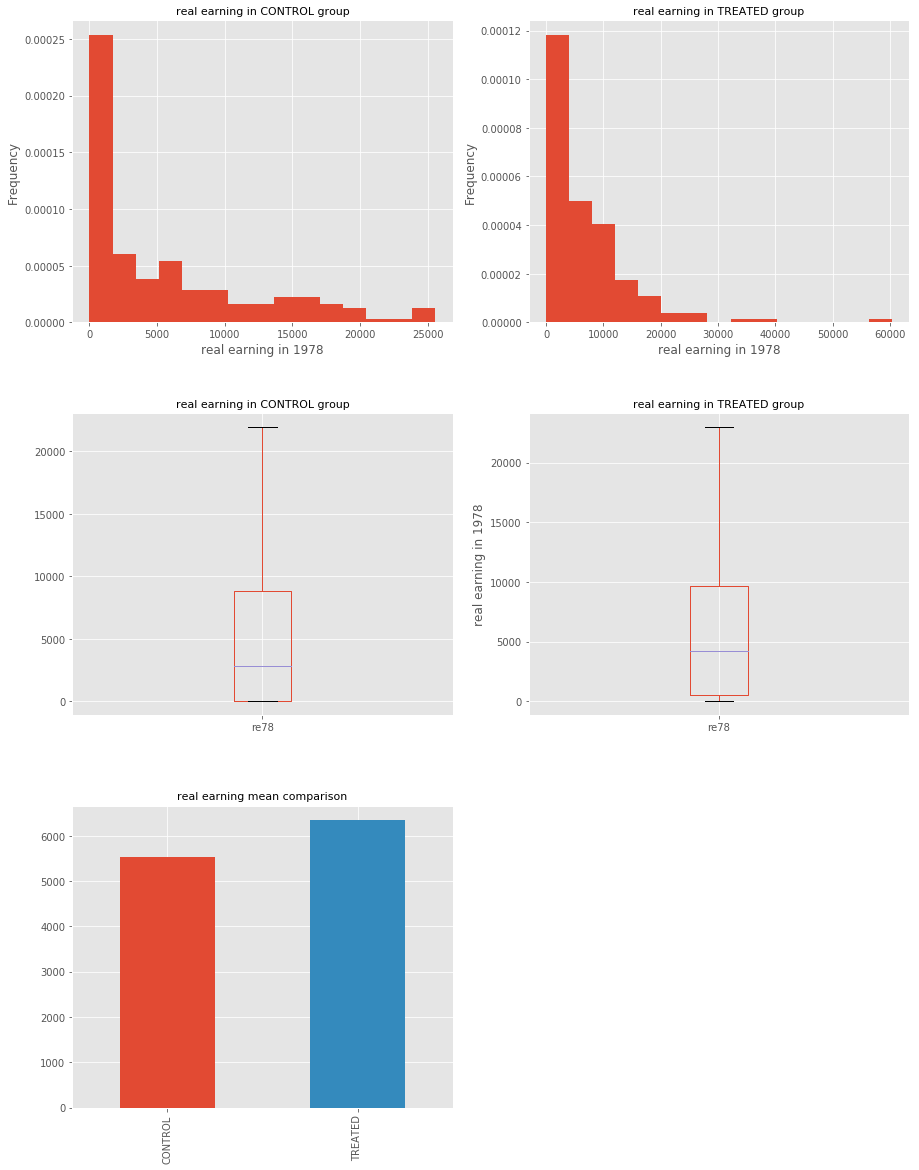

In [265]:
draw_earning_78_plot(balancedDataset)

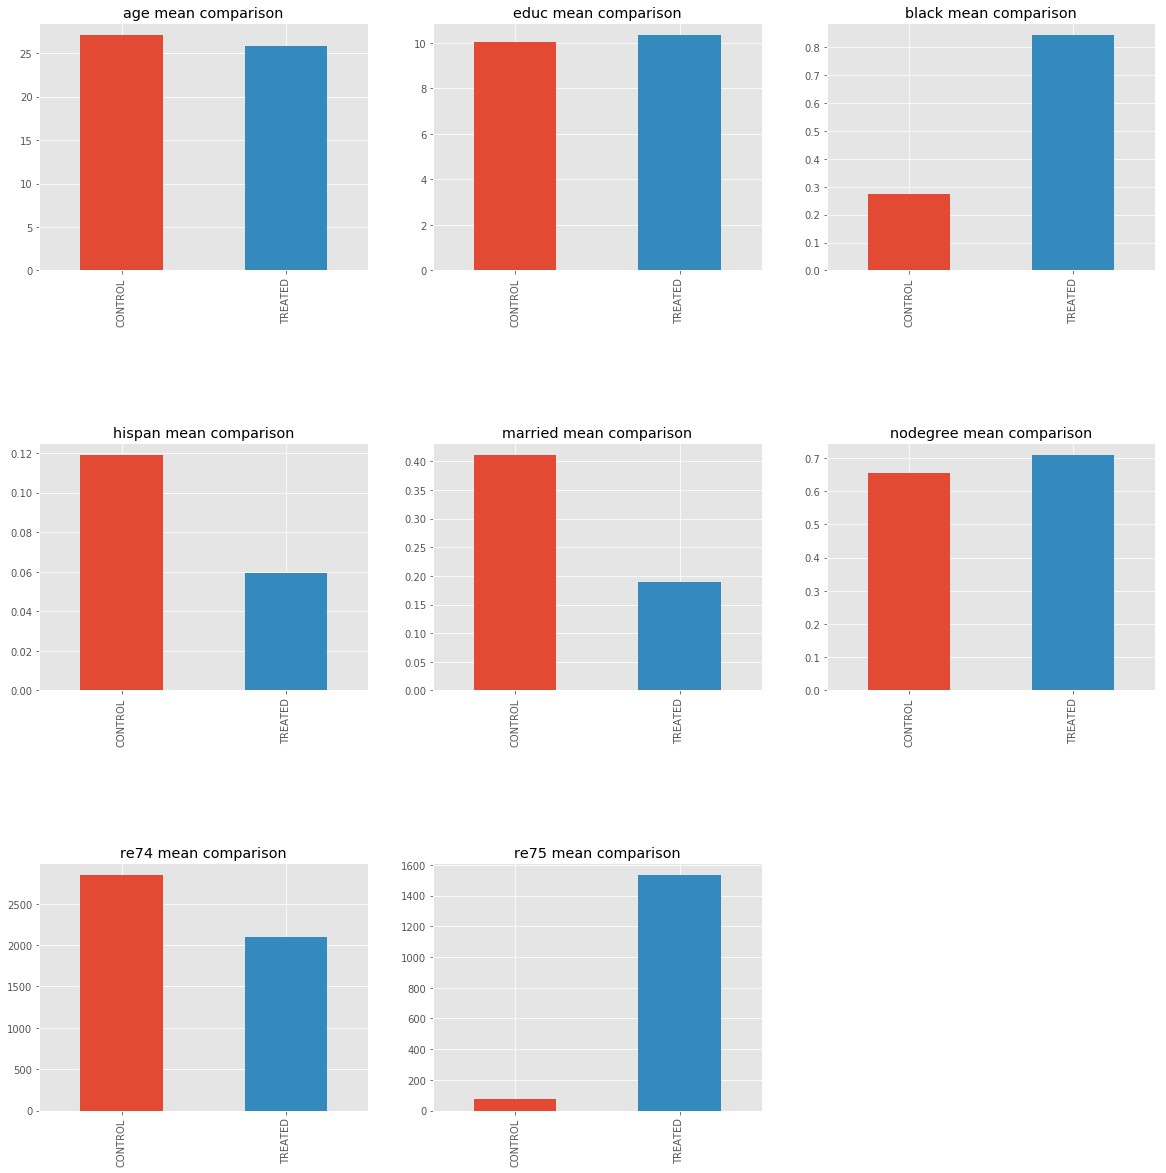

In [271]:
draw_feature_disparities_plot(balancedDataset)